## Web Scraper

In [117]:
import pandas as pd
import requests
import cloudscraper
import time, random
import re
from bs4 import BeautifulSoup
from datetime import datetime
from fake_useragent import UserAgent 

Testing on one link before trying to implement a function and apply to all countries of interest

<!DOCTYPE html>
<html class="no-js" data-root="/home/fb/deploy/www" data-version="klecko-" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
   <link href="https://cdn.ssref.net/req/202511051" rel="dns-prefetch"/>
   <script>
    /* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
   </script>
   <script src="https://cmp.osano.com/16CGnCU8
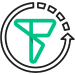
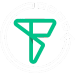

In [2]:
scraper = cloudscraper.create_scraper(delay=15)  
r = scraper.get("https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M")
soup = BeautifulSoup(r.text, "html.parser")
print(soup.prettify())

In [3]:
table = soup.find('div', attrs = {'id' : 'div_stats_304635c3_summary'}).find('table').find('tbody')
rows = table.find_all('tr')

# Example to display column elements more clearly
ex_row = rows[0]
for col in ex_row:
    ind = ex_row.index(col)
    print('index', ind, ' ' * (2-len(str(ind))), ' | ', col.text, ' ' * (12-len(col.text)), ' | ', col.get('data-stat'))

index 0    |  Rony           |  player
index 1    |  22             |  shirtnumber
index 2    |  FW             |  position
index 3    |  27-318         |  age
index 4    |  63             |  minutes
index 5    |  0              |  goals
index 6    |  0              |  assists
index 7    |  0              |  pens_made
index 8    |  0              |  pens_att
index 9    |                 |  shots
index 10   |                 |  shots_on_target
index 11   |  1              |  cards_yellow
index 12   |  0              |  cards_red
index 13   |                 |  fouls
index 14   |                 |  fouled
index 15   |                 |  offsides
index 16   |                 |  crosses
index 17   |                 |  tackles_won
index 18   |                 |  interceptions
index 19   |  0              |  own_goals
index 20   |                 |  pens_won
index 21   |                 |  pens_conceded


Finding captincy

In [33]:
soup.find_all('div', attrs={'class':'table_container tabbed current is_setup'})

[]

In [28]:
manager_n_cap = soup.find_all('div', attrs = {'class': 'datapoint'})
cap_name = [manager_n_cap[i].find('a').text for i in [1,3]]

Collect player data for all positions. Save data is stored in a different table. Will pull necessary data from that table if the position is for GK. Otherwise, will just fill the last col data with NA

In [ ]:
goalie_table = soup.find('div', attrs = {'id': 'div_keeper_stats_304635c3'}).find('table').find('tbody')

goal_rows = goalie_table.find_all('tr')

brazil_dat = []
for row in rows:
  name_col = row.find_all('th')
  stat_col = row.find_all('td')
  if len(name_col) > 0:
      name = name_col[0].text.strip()

      position = stat_col[1].text
      mins = stat_col[3].text
      goals = stat_col[4].texta
      assists = stat_col[5].text
      pens_made = stat_col[6].text
      pens_att = stat_col[7].text
      shots = stat_col[8].text
      shots_on_tar = stat_col[9].text
      yellow_cards = stat_col[10].text
      red_cards = stat_col[11].text
      
      if position == 'GK':
        for r in goal_rows:
          goal_stat = r.find_all('td')
          if len(stat_col) > 0:
            goal_against = goal_stat[3].text
            saves = goal_stat[4].text
            save_per = goal_stat[5].text
      else:
        goal_against = 'NA'
        saves = 'NA'
        save_per = 'NA'
      
      if name in cap_name:
        is_cap = 1
      else:
        is_cap = 0


      
  brazil_dat.append([name,mins,position,goals,assists,pens_made,pens_att,shots,shots_on_tar,yellow_cards,red_cards,goal_against,saves,save_per,is_cap])

In [6]:
brazil_dat[-1]

['Wéverton', '90', 'GK', '0', '0', '0', '0', '', '', '0', '0', '2', '', '', 0]

In [ ]:
import random, time

def get_safe(url, scraper, retries=3, base_delay=6):
    for i in range(retries):
        try:
            r = scraper.get(url)
        except Exception as e:
            print(f"Request error on attempt {i+1}: {e}")
            time.sleep(base_delay + random.uniform(5, 10))
            continue

        if r.status_code == 200:
            return r
        elif r.status_code == 429:
            wait = 180 + random.uniform(60, 180) # 3-6 minute cooldown if rate limited
            print(f"Rate limited (429). Cooling for {wait:.1f}s...")
            time.sleep(wait)
        elif r.status_code == 504:
            wait = 10 + random.uniform(5, 10)
            print(f"Gateway timeout (504). Waiting {wait:.1f}s before retry...")
            time.sleep(wait)
        else:
            print(f"Attempt {i+1}: Got status {r.status_code}. Retrying in 10s...")
            time.sleep(10 + random.uniform(0, 5))

    print(f"❌ All {retries} attempts failed for {url}")
    return None


Making the above a function to apply to multiple urls

In [ ]:
country_ids = {
    'Brazil': '304635c3'
    }
country_ids.get('Brazil')

'304635c3'

In [6]:
def match_log_scraper(url, scraper):
    
    r = get_safe(url, scraper)
    soup = BeautifulSoup(r.text, "html.parser")
    
    head_text = soup.find('h1').text
    teams = re.findall(r'([A-Za-z]+)\s+vs\.\s+([A-Za-z]+)', head_text)
    home_team, away_team = teams[0]
    
    dat = []
    
    for team in [home_team, away_team]:
        if team not in country_ids:
            continue  
        
        team_id = country_ids[team]
        
        table_div = soup.find('div', id=f'div_stats_{team_id}_summary')
        if not table_div:
            print(f"No summary table found for {team}")
            continue
        
        table = table_div.find('table')
        if not table:
            continue
        
        #pen data
        score_events = soup.find_all('div',class_='event_icon penalty_shootout_goal')
        miss_events = soup.find_all('div',class_='event_icon penalty_shootout_miss')
        
        scorers = []
        missers = []
        
        for score in score_events:
            scorers.append(score.findNextSibling().find('a').text)
        for miss in miss_events:
            missers.append(miss.findNextSibling().find('a').text)
        
        rows = table.find('tbody').find_all('tr')
        
        goalie_div = soup.find('div', id=f'div_keeper_stats_{team_id}')
        goal_rows = []
        if goalie_div and goalie_div.find('table'):
            goal_rows = goalie_div.find('table').find('tbody').find_all('tr')

        for row in rows:
            name_col = row.find_all('th')
            stat_col = row.find_all('td')
            if not name_col or not stat_col:
                continue

            name = name_col[0].text.strip()
            position = stat_col[1].text
            mins = stat_col[4].text
            goals = stat_col[5].text
            assists = stat_col[6].text
            pens_made = stat_col[7].text
            pens_att = stat_col[8].text
            shots = stat_col[9].text
            shots_on_tar = stat_col[10].text
            yellow_cards = stat_col[11].text
            red_cards = stat_col[12].text
            
            if position == 'GK' and goal_rows:
                gk_stats = goal_rows[0].find_all('td')  # assuming one GK row per team
                goal_against = gk_stats[3].text
                saves = gk_stats[4].text
                save_per = gk_stats[5].text
            else:
                goal_against = saves = save_per = 'NA'
                
            if name in scorers: 
                pen_shootout_scorer = 1 
            elif name in missers:
                pen_shootout_scorer = 0
            else:
                pen_shootout_scorer = 'NA'
            
            dat.append([
                team, name, mins, position, goals, assists, pens_made, pens_att,
                shots, shots_on_tar, yellow_cards, red_cards, pen_shootout_scorer,
                goal_against, saves, save_per
            ])

    return dat

In [129]:
match_log_scraper("https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M",scraper)

[['Brazil',
  'Rony',
  '0',
  'FW',
  '0',
  '0',
  '0',
  '',
  '',
  '1',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Antony',
  '0',
  'FW,MF',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Vinicius Júnior',
  '0',
  'FW',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Rodrygo',
  '0',
  'FW',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Vitor Roque',
  '0',
  'FW',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Lucas Paquetá',
  '0',
  'CM',
  '1',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Yuri Alberto',
  '0',
  'FW',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '',
  'NA',
  'NA',
  'NA',
  'NA'],
 ['Brazil',
  'Andrey Santos',
  '0',
  'CM',
  '0',
  '0',
  '0',
  '',
  '',
  '0',
  '0',
  '

## Applying to all countries now

This will pull the unique id for each country and then will use this to get the player stats data table for the specified country

In [35]:
country_ids = {
    'Brazil': '304635c3',
    'Canada': '9c6d90a0',
    'Mexico': 'b009a548',
    'USA': '0f66725b',
    'Japan': 'ffcf1690',
    'Korea Republic': '473f0fbf',
    'Uruguay': '870e020f',
    'Colombia': 'ab73cfe5',
    'England': '1862c019',
    'Spain': 'b561dd30',
    'Eygpt': 'b8889750',
    'France': 'b1b36dcd',
    'Portugal': '4a1b4ea8',
    'Germany': 'c1e40422',
    'Crotia': '7b08e376',
    'Argentina': 'f9fddd6e'
}


In [9]:
match_urls = pd.DataFrame(
[['Brazil','https://fbref.com/en/matches/4928c81b/Brazil-Bolivia-October-9-2020-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/5dcbc304/Peru-Brazil-October-13-2020-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/240cd6ea/Brazil-Venezuela-November-13-2020-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/200f1977/Uruguay-Brazil-November-17-2020-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/426bc821/Brazil-Ecuador-June-4-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/9476d029/Paraguay-Brazil-June-8-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/2bbbdd2e/Brazil-Venezuela-June-13-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/781f726c/Brazil-Colombia-June-23-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/9dbb8fff/Brazil-Ecuador-June-27-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/f73d3978/Brazil-Chile-July-2-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/17ac9b9b/Brazil-Peru-July-5-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/1309eaf0/Argentina-Brazil-July-10-2021-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/86e9755d/Chile-Brazil-September-2-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/412055d2/Brazil-Peru-September-9-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/9a5d9c01/Venezuela-Brazil-October-7-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/397cba16/Colombia-Brazil-October-10-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/48f7c36a/Brazil-Uruguay-October-14-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/4f932221/Brazil-Colombia-November-11-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/56b8bba4/Argentina-Brazil-November-16-2021-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/2115c0c8/Ecuador-Brazil-January-27-2022-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/8ce68c2d/Brazil-Paraguay-February-1-2022-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/d41effec/Brazil-Chile-March-24-2022-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/af491e1e/Bolivia-Brazil-March-29-2022-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/1ddc6610/Korea-Republic-Brazil-June-2-2022-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/f3f835c8/Japan-Brazil-June-6-2022-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/756dc6e1/Brazil-Ghana-September-23-2022-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/963b2d1a/Brazil-Tunisia-September-27-2022-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/457c3fcf/Brazil-Serbia-November-24-2022-World-Cup'],
 ['Brazil','https://fbref.com/en/matches/459240ee/Brazil-Switzerland-November-28-2022-World-Cup'],
 ['Brazil','https://fbref.com/en/matches/5a2cc3c5/Cameroon-Brazil-December-2-2022-World-Cup'],
 ['Brazil','https://fbref.com/en/matches/bc6994e8/Brazil-Korea-Republic-December-5-2022-World-Cup'],
 ['Brazil','https://fbref.com/en/matches/bb30147d/Croatia-Brazil-December-9-2022-World-Cup'],
 ['Brazil','https://fbref.com/en/matches/b9e2f869/Morocco-Brazil-March-25-2023-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/416b9e83/Brazil-Guinea-June-17-2023-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/9e972c43/Brazil-Senegal-June-20-2023-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/5eccc784/England-Brazil-March-23-2024-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/f47f2579/Spain-Brazil-March-26-2024-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/df95da27/Mexico-Brazil-June-8-2024-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/174bf942/United-States-Brazil-June-12-2024-Friendlies-M'],
 ['Brazil','https://fbref.com/en/matches/9e7417ae/Brazil-Costa-Rica-June-24-2024-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/db2faedf/Paraguay-Brazil-June-28-2024-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/438b034c/Brazil-Colombia-July-2-2024-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/c63a9e9c/Uruguay-Brazil-July-6-2024-Copa-America'],
 ['Brazil','https://fbref.com/en/matches/8da8f0c8/Brazil-Ecuador-September-6-2024-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/f40d8740/Paraguay-Brazil-September-10-2024-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/be9cefba/Chile-Brazil-October-10-2024-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/398f157e/Brazil-Peru-October-15-2024-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/bd726a09/Venezuela-Brazil-November-14-2024-WCQ----CONMEBOL-M'],
 ['Brazil','https://fbref.com/en/matches/23480dba/Japan-Brazil-October-14-2025-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/fe06d053/Canada-Bermuda-March-25-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/0880124d/Cayman-Islands-Canada-March-29-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/96977b99/Aruba-Canada-June-5-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/0d9dc87d/Canada-Suriname-June-8-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/7f2b0d0c/Haiti-Canada-June-12-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/f5a4982d/Canada-Haiti-June-15-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/8d758bc0/Canada-Martinique-July-11-2021-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/7e683a33/Haiti-Canada-July-15-2021-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/d6ce8cbf/United-States-Canada-July-18-2021-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/06373d21/Costa-Rica-Canada-July-25-2021-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/1491197a/Mexico-Canada-July-29-2021-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/7d0363bc/Canada-Honduras-September-2-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/4eadc8b5/United-States-Canada-September-5-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/b50f9e31/Canada-El-Salvador-September-8-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/837db4cf/Mexico-Canada-October-7-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/1913ac6e/Jamaica-Canada-October-10-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/b1253686/Canada-Panama-October-13-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/05b34a0a/Canada-Costa-Rica-November-12-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/24853275/Canada-Mexico-November-16-2021-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/f55deea5/Honduras-Canada-January-27-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/6c21289c/Canada-United-States-January-30-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/3c0e0640/El-Salvador-Canada-February-2-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/a251d489/Costa-Rica-Canada-March-24-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/afceef1d/Canada-Jamaica-March-27-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/78c127ae/Panama-Canada-March-30-2022-WCQ----CONCACAF-M'],
 ['Canada','https://fbref.com/en/matches/3f1c3c83/Qatar-Canada-September-23-2022-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/b90aca49/Canada-Uruguay-September-27-2022-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/30aa323b/Bahrain-Canada-November-11-2022-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/392beca6/Japan-Canada-November-17-2022-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/89c39a0a/Belgium-Canada-November-23-2022-World-Cup'],
 ['Canada','https://fbref.com/en/matches/6bac97fe/Croatia-Canada-November-27-2022-World-Cup'],
 ['Canada','https://fbref.com/en/matches/46776714/Canada-Morocco-December-1-2022-World-Cup'],
 ['Canada','https://fbref.com/en/matches/311cae3d/Canada-Guadeloupe-June-27-2023-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/e000f4d0/Guatemala-Canada-July-1-2023-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/6206941e/Canada-Cuba-July-4-2023-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/c60b4cc3/United-States-Canada-July-9-2023-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/a061b9e4/Japan-Canada-October-13-2023-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/a9595ceb/Netherlands-Canada-June-6-2024-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/c2178e11/France-Canada-June-9-2024-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/09240291/Argentina-Canada-June-20-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/56faeaf9/Peru-Canada-June-25-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/01a7c36f/Canada-Chile-June-29-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/ca63b471/Venezuela-Canada-July-5-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/4803e5f9/Argentina-Canada-July-9-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/2466e9ff/Canada-Uruguay-July-13-2024-Copa-America'],
 ['Canada','https://fbref.com/en/matches/03564011/United-States-Canada-September-7-2024-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/c39e721b/Mexico-Canada-September-10-2024-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/5663d52d/Canada-Panama-October-15-2024-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/5394707c/Canada-Honduras-June-17-2025-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/b59b0775/Curacao-Canada-June-21-2025-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/1f648796/Canada-El-Salvador-June-24-2025-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/7f3f63fc/Canada-Guatemala-June-29-2025-Gold-Cup'],
 ['Canada','https://fbref.com/en/matches/df18b1bf/Romania-Canada-September-5-2025-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/2606f817/Wales-Canada-September-9-2025-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/48db69ea/Canada-Australia-October-10-2025-Friendlies-M'],
 ['Canada','https://fbref.com/en/matches/b4f6d9bb/Colombia-Canada-October-14-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/27518b38/Mexico-Jamaica-September-2-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/b3ff1804/Costa-Rica-Mexico-September-5-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/b2b92dfc/Panama-Mexico-September-8-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/47f3ab07/Mexico-Honduras-October-10-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/56f5c2d5/El-Salvador-Mexico-October-13-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/e5bd0e9d/Mexico-Ecuador-October-27-2021-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/79a3bf11/United-States-Mexico-November-12-2021-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/ccd0fa71/Mexico-Chile-December-8-2021-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/4b84070f/Jamaica-Mexico-January-27-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/1e29286c/Mexico-Costa-Rica-January-30-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/70cf7955/Mexico-Panama-February-2-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/07494c1b/Mexico-United-States-March-24-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/cad049bf/Honduras-Mexico-March-27-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/43162214/Mexico-El-Salvador-March-30-2022-WCQ----CONCACAF-M'],
 ['Mexico','https://fbref.com/en/matches/db93baf0/Mexico-Guatemala-April-27-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/307abd97/Mexico-Nigeria-May-28-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/471f58e1/Mexico-Uruguay-June-2-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/8dd4f5d5/Mexico-Ecuador-June-5-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/30db455b/Mexico-Paraguay-August-31-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/1a2a6866/Mexico-Peru-September-24-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/d5bcb154/Mexico-Colombia-September-27-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/265007e8/Mexico-Iraq-November-9-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/48370637/Mexico-Sweden-November-16-2022-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/0f944fec/Mexico-Poland-November-22-2022-World-Cup'],
 ['Mexico','https://fbref.com/en/matches/d28d6c80/Argentina-Mexico-November-26-2022-World-Cup'],
 ['Mexico','https://fbref.com/en/matches/6d3741e9/Saudi-Arabia-Mexico-November-30-2022-World-Cup'],
 ['Mexico','https://fbref.com/en/matches/5704d9a4/United-States-Mexico-April-19-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/92dd8f1d/Mexico-Guatemala-June-7-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/efe5d0d8/Mexico-Cameroon-June-10-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/3aa8e5c2/Mexico-Honduras-June-25-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/9d68d61a/Haiti-Mexico-June-29-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/9f03baf0/Mexico-Qatar-July-2-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/63cfb108/Mexico-Costa-Rica-July-8-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/0befaa69/Jamaica-Mexico-July-12-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/661dd94b/Mexico-Panama-July-16-2023-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/812127cd/Mexico-Australia-September-9-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/16d1a4fe/Mexico-Uzbekistan-September-12-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/52b32b60/Mexico-Ghana-October-14-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/35c1c066/Mexico-Germany-October-17-2023-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/4bf89490/Mexico-Uruguay-June-5-2024-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/652c8ecd/Mexico-Jamaica-June-22-2024-Copa-America'],
 ['Mexico','https://fbref.com/en/matches/434eeeb4/Venezuela-Mexico-June-26-2024-Copa-America'],
 ['Mexico','https://fbref.com/en/matches/1e4d784d/Mexico-Ecuador-June-30-2024-Copa-America'],
 ['Mexico','https://fbref.com/en/matches/6df3e937/Mexico-New-Zealand-September-7-2024-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/57bbc128/Mexico-United-States-October-15-2024-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/2ac09510/Mexico-Switzerland-June-7-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/59942a6b/Mexico-Turkiye-June-10-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/032336c2/Mexico-Dominican-Republic-June-14-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/156e335f/Suriname-Mexico-June-18-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/fe51f1f1/Mexico-Costa-Rica-June-22-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/0ddc176b/Mexico-Saudi-Arabia-June-28-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/046f5558/Mexico-Honduras-July-2-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/76d971d4/United-States-Mexico-July-6-2025-Gold-Cup'],
 ['Mexico','https://fbref.com/en/matches/f4fd57a9/Mexico-Japan-September-6-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/2ea82378/Mexico-Korea-Republic-September-9-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/e2aae0bb/Mexico-Colombia-October-11-2025-Friendlies-M'],
 ['Mexico','https://fbref.com/en/matches/380c7bdb/Mexico-Ecuador-October-14-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/7734d999/El-Salvador-United-States-September-2-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/ea786b93/Honduras-United-States-September-8-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/b82ee796/United-States-Jamaica-October-7-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/3999b55b/Panama-United-States-October-10-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/57d0c2c6/United-States-Costa-Rica-October-13-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/b2289ca6/Jamaica-United-States-November-16-2021-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/db256c22/United-States-Bosnia-and-Herzegovina-December-18-2021-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/a1ba697e/United-States-El-Salvador-January-27-2022-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/a790a017/United-States-Honduras-February-2-2022-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/13c77536/United-States-Panama-March-27-2022-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/5931a7e7/Costa-Rica-United-States-March-30-2022-WCQ----CONCACAF-M'],
 ['USA','https://fbref.com/en/matches/1f428d10/United-States-Morocco-June-1-2022-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/676aab42/Japan-United-States-September-23-2022-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/56bde19a/Saudi-Arabia-United-States-September-27-2022-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/9de4c4cc/United-States-Wales-November-21-2022-World-Cup'],
 ['USA','https://fbref.com/en/matches/cde0c30b/England-United-States-November-25-2022-World-Cup'],
 ['USA','https://fbref.com/en/matches/dcd3b239/IR-Iran-United-States-November-29-2022-World-Cup'],
 ['USA','https://fbref.com/en/matches/249ccad4/Netherlands-United-States-December-3-2022-World-Cup'],
 ['USA','https://fbref.com/en/matches/53271555/United-States-Serbia-January-25-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/3f6bd619/United-States-Colombia-January-28-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/2ec267fb/United-States-Jamaica-June-24-2023-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/e9794333/St-Kitts-and-Nevis-United-States-June-28-2023-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/375cc93b/United-States-Trinidad-and-Tobago-July-2-2023-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/80b3c928/United-States-Panama-July-12-2023-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/66385fb9/United-States-Uzbekistan-September-9-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/7664b57a/United-States-Oman-September-12-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/a392d272/United-States-Germany-October-14-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/3ac52860/United-States-Ghana-October-17-2023-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/dfe60a21/United-States-Colombia-June-8-2024-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/f4baac63/United-States-Bolivia-June-23-2024-Copa-America'],
 ['USA','https://fbref.com/en/matches/eb5b0b7b/Panama-United-States-June-27-2024-Copa-America'],
 ['USA','https://fbref.com/en/matches/3597f034/United-States-Uruguay-July-1-2024-Copa-America'],
 ['USA','https://fbref.com/en/matches/8875ce65/United-States-New-Zealand-September-10-2024-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/dac3581c/United-States-Panama-October-12-2024-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/e3fffdb3/United-States-Venezuela-January-18-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/83029af8/United-States-Costa-Rica-January-22-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/c24f747b/United-States-Turkiye-June-7-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/81fbeb3b/United-States-Switzerland-June-10-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/7576e6c0/United-States-Trinidad-and-Tobago-June-15-2025-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/7ad35ca2/Saudi-Arabia-United-States-June-19-2025-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/94f436b0/United-States-Haiti-June-22-2025-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/20035769/United-States-Costa-Rica-June-29-2025-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/9f090891/United-States-Guatemala-July-2-2025-Gold-Cup'],
 ['USA','https://fbref.com/en/matches/ea2adc8c/United-States-Korea-Republic-September-6-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/9dd21a65/United-States-Japan-September-9-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/d53e2357/United-States-Ecuador-October-10-2025-Friendlies-M'],
 ['USA','https://fbref.com/en/matches/3e07a440/United-States-Australia-October-14-2025-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/8c3a2e96/Myanmar-Japan-September-10-2019-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/13a54b3a/Japan-Mongolia-October-10-2019-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/cfe8cdf6/Tajikistan-Japan-October-15-2019-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/9b2d823a/Kyrgyz-Republic-Japan-November-14-2019-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/4f89c343/Japan-Venezuela-November-19-2019-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/b2a79681/Japan-Cameroon-October-9-2020-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/c3cff4a7/Japan-Cote-dIvoire-October-13-2020-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/3d35218e/Japan-Panama-November-13-2020-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/08844b04/Japan-Mexico-November-17-2020-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/e3a0b447/Japan-Korea-Republic-March-25-2021-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/de2d78da/Mongolia-Japan-March-30-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/35faea27/Japan-Myanmar-May-28-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/2ea996bc/Japan-Tajikistan-June-7-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/3c376aad/Japan-Serbia-June-11-2021-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/8e62935f/Japan-Kyrgyz-Republic-June-15-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/3b7a6426/Japan-Oman-September-2-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/c9b8bcad/China-PR-Japan-September-7-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/8158c5a6/Saudi-Arabia-Japan-October-7-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/b76f4f34/Japan-Australia-October-12-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/8a18c5f1/Vietnam-Japan-November-11-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/2fc01859/Oman-Japan-November-16-2021-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/377b7af0/Japan-China-PR-January-27-2022-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/54201ca9/Japan-Saudi-Arabia-February-1-2022-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/5e90edde/Australia-Japan-March-24-2022-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/424f8b1d/Japan-Vietnam-March-29-2022-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/3dbdcb9f/Japan-Paraguay-June-2-2022-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/f4513452/Japan-Ecuador-September-27-2022-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/a3556b5a/Germany-Japan-November-23-2022-World-Cup'],
 ['Japan','https://fbref.com/en/matches/d56309f4/Japan-Costa-Rica-November-27-2022-World-Cup'],
 ['Japan','https://fbref.com/en/matches/f04828fe/Japan-Spain-December-1-2022-World-Cup'],
 ['Japan','https://fbref.com/en/matches/4e74d7ed/Japan-Croatia-December-5-2022-World-Cup'],
 ['Japan','https://fbref.com/en/matches/e7dd2c0e/Japan-Uruguay-March-24-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/bb3cac85/Japan-Colombia-March-28-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/01f27902/Japan-El-Salvador-June-15-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/356df425/Japan-Peru-June-20-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/cfc6f12b/Germany-Japan-September-9-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/df8aaf47/Japan-Turkiye-September-12-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/964dcc12/Japan-Tunisia-October-17-2023-Friendlies-M'],
 ['Japan','https://fbref.com/en/matches/1ea987f4/Japan-Myanmar-November-16-2023-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/62e1e28b/Syria-Japan-November-21-2023-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/7f84f12f/Japan-Vietnam-January-14-2024-Asian-Cup'],
 ['Japan','https://fbref.com/en/matches/02a6c8dc/Iraq-Japan-January-19-2024-Asian-Cup'],
 ['Japan','https://fbref.com/en/matches/33b918a9/Japan-Indonesia-January-24-2024-Asian-Cup'],
 ['Japan','https://fbref.com/en/matches/da51c1ed/Bahrain-Japan-January-31-2024-Asian-Cup'],
 ['Japan','https://fbref.com/en/matches/c0d73f9e/IR-Iran-Japan-February-3-2024-Asian-Cup'],
 ['Japan','https://fbref.com/en/matches/9402d6e2/Japan-Korea-DPR-March-21-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/dadb666e/Korea-DPR-Japan-March-26-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/1da5aefb/Myanmar-Japan-June-6-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/1e1e0432/Japan-Syria-June-11-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/1dc362ac/Japan-China-PR-September-5-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/b9b375c2/Bahrain-Japan-September-10-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/19cbb8b1/Saudi-Arabia-Japan-October-10-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/53fa3c4e/Japan-Australia-October-15-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/822b50cd/Indonesia-Japan-November-15-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/55f958d8/China-PR-Japan-November-19-2024-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/909338e3/Japan-Bahrain-March-20-2025-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/30695e3b/Japan-Saudi-Arabia-March-25-2025-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/ae130257/Australia-Japan-June-5-2025-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/f448bf08/Japan-Indonesia-June-10-2025-WCQ----AFC-M'],
 ['Japan','https://fbref.com/en/matches/d3c62f27/Japan-Paraguay-October-10-2025-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/fc0b25d4/Turkmenistan-Korea-Republic-September-10-2019-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/bc33066e/Korea-Republic-Sri-Lanka-October-10-2019-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/b4f971c0/Lebanon-Korea-Republic-November-14-2019-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/59ca2e24/Brazil-Korea-Republic-November-19-2019-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/65609b97/Mexico-Korea-Republic-November-14-2020-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/9151e0bf/Korea-Republic-Qatar-November-17-2020-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/684fd6f3/Korea-Republic-Turkmenistan-June-5-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/21aea9f9/Sri-Lanka-Korea-Republic-June-9-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/e80defca/Korea-Republic-Lebanon-June-13-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/8d515753/Korea-Republic-Iraq-September-2-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/a49a57ff/Korea-Republic-Lebanon-September-7-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/cbff573f/Korea-Republic-Syria-October-7-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/15f914e4/IR-Iran-Korea-Republic-October-12-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/0907c381/Korea-Republic-United-Arab-Emirates-November-11-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/7d1bb48f/Iraq-Korea-Republic-November-16-2021-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/0cd9759e/Korea-Republic-Iceland-January-15-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/35e9008d/Korea-Republic-Moldova-January-21-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/f6877f72/Lebanon-Korea-Republic-January-27-2022-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/8293c44f/Syria-Korea-Republic-February-1-2022-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/7fc1ba19/Korea-Republic-IR-Iran-March-24-2022-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/1e271938/United-Arab-Emirates-Korea-Republic-March-29-2022-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/765d2fc8/Korea-Republic-Chile-June-6-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/cc7e9a10/Korea-Republic-Paraguay-June-10-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/893f4714/Korea-Republic-Egypt-June-14-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/ce791cfe/Korea-Republic-Costa-Rica-September-23-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/f18f7fed/Korea-Republic-Cameroon-September-27-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/786899bb/Korea-Republic-Iceland-November-11-2022-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/878d5504/Uruguay-Korea-Republic-November-24-2022-World-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/38069bed/Korea-Republic-Ghana-November-28-2022-World-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/341e520f/Korea-Republic-Portugal-December-2-2022-World-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/fc5209bc/Korea-Republic-Colombia-March-24-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/111100a5/Korea-Republic-Uruguay-March-28-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/c7ed915e/Korea-Republic-Peru-June-16-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/217d4eb7/Korea-Republic-El-Salvador-June-20-2023-Friendlies-M'],
 ['Korea Repubilc','https://fbref.com/en/matches/c1557631/Wales-Korea-Republic-September-7-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/9c3529eb/Saudi-Arabia-Korea-Republic-September-12-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/938b4f5f/Korea-Republic-Tunisia-October-13-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/632cb5b9/Korea-Republic-Vietnam-October-17-2023-Friendlies-M'],
 ['Korea Republic','https://fbref.com/en/matches/03fcde90/Korea-Republic-Singapore-November-16-2023-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/d7b8ab3d/China-PR-Korea-Republic-November-21-2023-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/61f04936/Korea-Republic-Bahrain-January-15-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/ccc3108d/Jordan-Korea-Republic-January-20-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/f2aa0cb3/Korea-Republic-Malaysia-January-25-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/12d616de/Saudi-Arabia-Korea-Republic-January-30-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/6fdc7d22/Australia-Korea-Republic-February-2-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/31bdfbdb/Jordan-Korea-Republic-February-6-2024-Asian-Cup'],
 ['Korea Republic','https://fbref.com/en/matches/5620715c/Korea-Republic-Thailand-March-21-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/7bcd7348/Thailand-Korea-Republic-March-26-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/e8a870da/Singapore-Korea-Republic-June-6-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/a9032a94/Korea-Republic-China-PR-June-11-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/c95bcad6/Korea-Republic-Palestine-September-5-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/ec1883b2/Oman-Korea-Republic-September-10-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/aa794aa7/Jordan-Korea-Republic-October-10-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/ad95fa29/Korea-Republic-Iraq-October-15-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/c24b5438/Kuwait-Korea-Republic-November-14-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/70c665e7/Palestine-Korea-Republic-November-19-2024-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/d4f2ffe2/Korea-Republic-Oman-March-20-2025-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/cbfbb5e5/Korea-Republic-Jordan-March-25-2025-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/8a15f138/Iraq-Korea-Republic-June-5-2025-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/898e1bb9/Korea-Republic-Kuwait-June-10-2025-WCQ----AFC-M'],
 ['Korea Republic','https://fbref.com/en/matches/e504860c/Korea-Republic-Paraguay-October-14-2025-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/22e4118a/Uruguay-Chile-October-8-2020-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/f7e0f805/Ecuador-Uruguay-October-13-2020-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/7e293483/Colombia-Uruguay-November-13-2020-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/7303b11e/Uruguay-Paraguay-June-3-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/b131c409/Venezuela-Uruguay-June-8-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/38597a51/Argentina-Uruguay-June-18-2021-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/2ca2b73a/Uruguay-Chile-June-21-2021-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/98d1d29f/Bolivia-Uruguay-June-24-2021-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/e000faa4/Uruguay-Paraguay-June-28-2021-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/0b8ca785/Uruguay-Colombia-July-3-2021-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/9c62d11d/Peru-Uruguay-September-2-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/2b7eb917/Uruguay-Bolivia-September-5-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/2f1f8b9b/Uruguay-Ecuador-September-9-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/b22cd290/Uruguay-Colombia-October-7-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/60d07fdd/Argentina-Uruguay-October-10-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/3118bc39/Uruguay-Argentina-November-12-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/dfdb28c6/Bolivia-Uruguay-November-16-2021-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/e2711cae/Paraguay-Uruguay-January-27-2022-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/7a366fd8/Uruguay-Venezuela-February-1-2022-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/2c7cca3b/Uruguay-Peru-March-24-2022-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/b0fdaa5b/Chile-Uruguay-March-29-2022-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/0542214a/IR-Iran-Uruguay-September-23-2022-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/90fded8a/Portugal-Uruguay-November-28-2022-World-Cup'],
 ['Uruguay','https://fbref.com/en/matches/0b62abf2/Ghana-Uruguay-December-2-2022-World-Cup'],
 ['Uruguay','https://fbref.com/en/matches/0f43eb7c/Uruguay-Nicaragua-June-14-2023-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/04a468e4/Uruguay-Cuba-June-20-2023-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/a3fac10c/Uruguay-Chile-September-8-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/37e01439/Ecuador-Uruguay-September-12-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/69c44fb6/Colombia-Uruguay-October-12-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/234290bd/Uruguay-Brazil-October-17-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/863e2131/Argentina-Uruguay-November-16-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/5f1085fe/Uruguay-Bolivia-November-21-2023-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/6ddfd148/Cote-dIvoire-Uruguay-March-26-2024-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/504e7c6b/Uruguay-Panama-June-23-2024-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/873350d2/Uruguay-Bolivia-June-27-2024-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/08d6e96b/Uruguay-Colombia-July-10-2024-Copa-America'],
 ['Uruguay','https://fbref.com/en/matches/87b3dc5b/Uruguay-Paraguay-September-6-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/3c0cdf72/Venezuela-Uruguay-September-10-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/67e91e6b/Peru-Uruguay-October-11-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/d046b8a6/Uruguay-Ecuador-October-15-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/68a63ecd/Uruguay-Colombia-November-15-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/1d7d18d3/Brazil-Uruguay-November-19-2024-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/d640293b/Uruguay-Argentina-March-21-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/bed222ed/Bolivia-Uruguay-March-25-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/cf0d5a07/Paraguay-Uruguay-June-5-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/a4cbcbc8/Uruguay-Venezuela-June-10-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/9692d63b/Uruguay-Peru-September-4-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/fdc625fd/Chile-Uruguay-September-9-2025-WCQ----CONMEBOL-M'],
 ['Uruguay','https://fbref.com/en/matches/2afab4ef/Uruguay-Dominican-Republic-October-10-2025-Friendlies-M'],
 ['Uruguay','https://fbref.com/en/matches/21425ab9/Uzbekistan-Uruguay-October-13-2025-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/93790aa0/Colombia-Venezuela-October-9-2020-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/8ef2e353/Chile-Colombia-October-13-2020-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/d27d19d9/Ecuador-Colombia-November-17-2020-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/9f28c638/Peru-Colombia-June-3-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/1dba7872/Colombia-Argentina-June-8-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/575f2d83/Colombia-Ecuador-June-13-2021-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/90ca4fd2/Colombia-Venezuela-June-17-2021-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/8f2681f9/Colombia-Peru-June-20-2021-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/6122c6fc/Argentina-Colombia-July-6-2021-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/cbd151df/Colombia-Peru-July-9-2021-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/55d031db/Bolivia-Colombia-September-2-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/45bfd8f1/Paraguay-Colombia-September-5-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/05c8c607/Colombia-Chile-September-9-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/6e01b176/Colombia-Ecuador-October-14-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/ab7131ad/Colombia-Paraguay-November-16-2021-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/570866f0/Colombia-Honduras-January-16-2022-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/a0776529/Colombia-Peru-January-28-2022-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/493cc195/Argentina-Colombia-February-1-2022-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/a3059e67/Colombia-Bolivia-March-24-2022-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/638ec300/Venezuela-Colombia-March-29-2022-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/a2a508d6/Saudi-Arabia-Colombia-June-5-2022-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/ad1cadfb/Colombia-Guatemala-September-24-2022-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/cafa65c5/Colombia-Paraguay-November-19-2022-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/4942bfd2/Colombia-Iraq-June-16-2023-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/19327273/Germany-Colombia-June-20-2023-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/65227f28/Colombia-Venezuela-September-7-2023-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/acc6c6da/Chile-Colombia-September-12-2023-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/bbd48b0c/Ecuador-Colombia-October-17-2023-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/d050b216/Colombia-Brazil-November-16-2023-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/6c72239f/Paraguay-Colombia-November-21-2023-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/521f08e2/Spain-Colombia-March-22-2024-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/86f9c8c3/Colombia-Romania-March-26-2024-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/741934dd/Colombia-Bolivia-June-15-2024-Friendlies-M'],
 ['Colombia','https://fbref.com/en/matches/5b537cd5/Colombia-Paraguay-June-24-2024-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/a79510cb/Colombia-Costa-Rica-June-28-2024-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/1cf59899/Colombia-Panama-July-6-2024-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/39b037a9/Argentina-Colombia-July-14-2024-Copa-America'],
 ['Colombia','https://fbref.com/en/matches/9800bfd8/Peru-Colombia-September-6-2024-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/a116795c/Colombia-Argentina-September-10-2024-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/cf073fac/Bolivia-Colombia-October-10-2024-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/e5141722/Colombia-Chile-October-15-2024-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/58dcd927/Colombia-Ecuador-November-19-2024-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/8113f03f/Brazil-Colombia-March-20-2025-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/bb3b96c6/Colombia-Paraguay-March-25-2025-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/72e0f65c/Colombia-Peru-June-6-2025-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/25a7c42b/Argentina-Colombia-June-10-2025-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/246e206c/Colombia-Bolivia-September-4-2025-WCQ----CONMEBOL-M'],
 ['Colombia','https://fbref.com/en/matches/0c0d07af/Venezuela-Colombia-September-9-2025-WCQ----CONMEBOL-M'],
 ['England','https://fbref.com/en/matches/cbc6958a/England-San-Marino-March-25-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/c85000c6/Albania-England-March-28-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/3b0947fb/England-Poland-March-31-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/e7853555/England-Austria-June-2-2021-Friendlies-M'],
 ['England','https://fbref.com/en/matches/96ad6daa/England-Romania-June-6-2021-Friendlies-M'],
 ['England','https://fbref.com/en/matches/764c27dc/England-Croatia-June-13-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/027b11df/England-Scotland-June-18-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/20b1972b/Czechia-England-June-22-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/415ff832/England-Germany-June-29-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/8589d5c5/Ukraine-England-July-3-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/3c9e014a/England-Denmark-July-7-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/56228480/Italy-England-July-11-2021-UEFA-Euro-2020'],
 ['England','https://fbref.com/en/matches/7612db0b/Hungary-England-September-2-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/cebf498c/England-Andorra-September-5-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/d13f36b8/Poland-England-September-8-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/aaa2a351/Andorra-England-October-9-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/ff6936ad/England-Hungary-October-12-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/a7100028/England-Albania-November-12-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/4a3eae2f/San-Marino-England-November-15-2021-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/3a98668d/England-Switzerland-March-26-2022-Friendlies-M'],
 ['England','https://fbref.com/en/matches/ed214e41/England-Cote-dIvoire-March-29-2022-Friendlies-M'],
 ['England','https://fbref.com/en/matches/058c813b/Hungary-England-June-4-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/d7df9e02/Germany-England-June-7-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/c75dc433/England-Italy-June-11-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/c8aefffb/England-Hungary-June-14-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/5b0ffbe3/Italy-England-September-23-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/03055401/England-Germany-September-26-2022-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/d8a472c1/England-IR-Iran-November-21-2022-World-Cup'],
 ['England','https://fbref.com/en/matches/e51b7436/Wales-England-November-29-2022-World-Cup'],
 ['England','https://fbref.com/en/matches/a323f701/England-Senegal-December-4-2022-World-Cup'],
 ['England','https://fbref.com/en/matches/6d4b58f5/England-France-December-10-2022-World-Cup'],
 ['England','https://fbref.com/en/matches/64af7b32/Italy-England-March-23-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/275ada90/England-Ukraine-March-26-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/ec84182e/Malta-England-June-16-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/40be9cd8/England-North-Macedonia-June-19-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/a067451d/Ukraine-England-September-9-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/1461ddd6/Scotland-England-September-12-2023-Friendlies-M'],
 ['England','https://fbref.com/en/matches/b1fbabe1/England-Australia-October-13-2023-Friendlies-M'],
 ['England','https://fbref.com/en/matches/8f7bca34/England-Italy-October-17-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/10b73457/England-Malta-November-17-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/a7fd04d1/North-Macedonia-England-November-20-2023-UEFA-Euro-Qualifying'],
 ['England','https://fbref.com/en/matches/5cac400a/England-Belgium-March-26-2024-Friendlies-M'],
 ['England','https://fbref.com/en/matches/43e013da/England-Bosnia-and-Herzegovina-June-3-2024-Friendlies-M'],
 ['England','https://fbref.com/en/matches/932ff5e7/England-Iceland-June-7-2024-Friendlies-M'],
 ['England','https://fbref.com/en/matches/94c752b7/Serbia-England-June-16-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/6cfeccb2/Denmark-England-June-20-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/7f111a22/England-Slovenia-June-25-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/2b26dc4f/England-Slovakia-June-30-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/54e21415/England-Switzerland-July-6-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/dbff0752/Netherlands-England-July-10-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/e307ecc0/Spain-England-July-14-2024-UEFA-Euro-2024'],
 ['England','https://fbref.com/en/matches/aba0cc5d/Republic-of-Ireland-England-September-7-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/615b20a6/England-Finland-September-10-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/2f27c6be/England-Greece-October-10-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/79f19251/Finland-England-October-13-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/2a3a5d7a/Greece-England-November-14-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/90b203d7/England-Republic-of-Ireland-November-17-2024-UEFA-Nations-League'],
 ['England','https://fbref.com/en/matches/9d4a21a1/England-Albania-March-21-2025-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/e2b397bc/England-Latvia-March-24-2025-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/e7d39bec/Andorra-England-June-7-2025-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/262ec884/England-Senegal-June-10-2025-Friendlies-M'],
 ['England','https://fbref.com/en/matches/533e2793/England-Andorra-September-6-2025-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/df596a54/Serbia-England-September-9-2025-WCQ----UEFA-M'],
 ['England','https://fbref.com/en/matches/7be409cd/England-Wales-October-9-2025-Friendlies-M'],
 ['England','https://fbref.com/en/matches/dfcc36f5/Latvia-England-October-14-2025-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/9b689536/Spain-Greece-March-25-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/4e0237d2/Georgia-Spain-March-28-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/e746a4d9/Spain-Kosovo-March-31-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/9df344e7/Spain-Portugal-June-4-2021-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/ed527333/Spain-Lithuania-June-8-2021-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/107fd412/Spain-Sweden-June-14-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/14874531/Spain-Poland-June-19-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/7b46b857/Slovakia-Spain-June-23-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/799efcfc/Croatia-Spain-June-28-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/18c4e831/Switzerland-Spain-July-2-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/997fefb3/Italy-Spain-July-6-2021-UEFA-Euro-2020'],
 ['Spain','https://fbref.com/en/matches/a2c7d162/Sweden-Spain-September-2-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/c964cf05/Spain-Georgia-September-5-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/d17ef599/Kosovo-Spain-September-8-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/5c6a2cfd/Italy-Spain-October-6-2021-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/82df6636/Spain-France-October-10-2021-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/f7183877/Greece-Spain-November-11-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/d774904e/Spain-Sweden-November-14-2021-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/2e427819/Spain-Albania-March-26-2022-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/c2262bba/Spain-Iceland-March-29-2022-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/2ab716f3/Spain-Portugal-June-2-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/3287891e/Czechia-Spain-June-5-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/ef1c7234/Switzerland-Spain-June-9-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/6f7c35cc/Spain-Czechia-June-12-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/b0b7d557/Spain-Switzerland-September-24-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/ea9d78a0/Portugal-Spain-September-27-2022-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/dadb1883/Spain-Costa-Rica-November-23-2022-World-Cup'],
 ['Spain','https://fbref.com/en/matches/9397f79c/Spain-Germany-November-27-2022-World-Cup'],
 ['Spain','https://fbref.com/en/matches/4c0aa6b0/Morocco-Spain-December-6-2022-World-Cup'],
 ['Spain','https://fbref.com/en/matches/4a800e3f/Spain-Norway-March-25-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/1a041b62/Scotland-Spain-March-28-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/d5acf882/Spain-Italy-June-15-2023-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/c7cc0ff5/Croatia-Spain-June-18-2023-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/5993cfc5/Georgia-Spain-September-8-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/4409f65b/Spain-Cyprus-September-12-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/816e3943/Spain-Scotland-October-12-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/9d087fa7/Norway-Spain-October-15-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/6b5fa8f8/Cyprus-Spain-November-16-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/d0538cf2/Spain-Georgia-November-19-2023-UEFA-Euro-Qualifying'],
 ['Spain','https://fbref.com/en/matches/4482be20/Spain-Andorra-June-5-2024-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/05d97421/Spain-Northern-Ireland-June-8-2024-Friendlies-M'],
 ['Spain','https://fbref.com/en/matches/b996c4de/Spain-Croatia-June-15-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/3f7c6e94/Spain-Italy-June-20-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/fde83534/Albania-Spain-June-24-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/87e35d10/Spain-Georgia-June-30-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/0baf4cfa/Spain-Germany-July-5-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/34d4d9d2/Spain-France-July-9-2024-UEFA-Euro-2024'],
 ['Spain','https://fbref.com/en/matches/5469aa22/Serbia-Spain-September-5-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/74ac9e75/Switzerland-Spain-September-8-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/a2426b82/Spain-Denmark-October-12-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/b1e0a75a/Spain-Serbia-October-15-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/be1b73c9/Denmark-Spain-November-15-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/d1bca41e/Spain-Switzerland-November-18-2024-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/537bba86/Netherlands-Spain-March-20-2025-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/12ea1c04/Spain-Netherlands-March-23-2025-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/cda3f996/Spain-France-June-5-2025-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/dc399ca6/Portugal-Spain-June-8-2025-UEFA-Nations-League'],
 ['Spain','https://fbref.com/en/matches/73a00b64/Bulgaria-Spain-September-4-2025-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/109a2359/Turkiye-Spain-September-7-2025-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/f6ab9dc9/Spain-Georgia-October-11-2025-WCQ----UEFA-M'],
 ['Spain','https://fbref.com/en/matches/90e53e80/Spain-Bulgaria-October-14-2025-WCQ----UEFA-M'],
 ['Egypt','https://fbref.com/en/matches/c3b7c811/Egypt-Angola-September-1-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/66675dea/Gabon-Egypt-September-5-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/f9c325c6/Egypt-Libya-October-8-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/9328c02e/Libya-Egypt-October-11-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/796c5f50/Angola-Egypt-November-12-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/a6c1c68d/Egypt-Gabon-November-16-2021-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/9f0fc8e7/Nigeria-Egypt-January-11-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/c80d5628/Guinea-Bissau-Egypt-January-15-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/5eecca28/Egypt-Sudan-January-19-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/ddd18729/Cote-dIvoire-Egypt-January-26-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/5b66173c/Egypt-Morocco-January-30-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/409101a3/Cameroon-Egypt-February-3-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/2ca5b81c/Senegal-Egypt-February-6-2022-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/d430cf43/Egypt-Senegal-March-25-2022-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/03a95112/Senegal-Egypt-March-29-2022-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/587f526a/Egypt-Guinea-June-5-2022-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/a4cc762b/Ethiopia-Egypt-June-9-2022-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/66e75a68/Egypt-Niger-September-23-2022-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/24daf61b/Egypt-Liberia-September-27-2022-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/0e00c872/Egypt-Belgium-November-18-2022-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/a2c09d33/Egypt-Malawi-March-24-2023-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/a3461cd4/Malawi-Egypt-March-28-2023-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/27765537/Guinea-Egypt-June-14-2023-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/6667f23f/Egypt-South-Sudan-June-18-2023-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/ce1b8b7b/Egypt-Ethiopia-September-8-2023-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/5074b7ec/Egypt-Tunisia-September-12-2023-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/cdca6081/Egypt-Zambia-October-12-2023-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/92d18ba8/Egypt-Algeria-October-16-2023-Friendlies-M'],
 ['Egypt','https://fbref.com/en/matches/e374c8dd/Egypt-Djibouti-November-16-2023-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/c1d9c52e/Sierra-Leone-Egypt-November-19-2023-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/b4accf41/Egypt-Mozambique-January-14-2024-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/4335f5ee/Egypt-Ghana-January-18-2024-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/509931aa/Cape-Verde-Egypt-January-22-2024-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/9f36f6bd/Egypt-Congo-DR-January-28-2024-Africa-Cup-of-Nations'],
 ['Egypt','https://fbref.com/en/matches/246d17f5/Egypt-Burkina-Faso-June-6-2024-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/5f1718d0/Guinea-Bissau-Egypt-June-10-2024-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/27f9e7de/Egypt-Cape-Verde-September-6-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/cf5e8ddb/Botswana-Egypt-September-10-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/48017b88/Egypt-Mauritania-October-11-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/351068c6/Mauritania-Egypt-October-15-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/4e200f2f/Cape-Verde-Egypt-November-15-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/3e6a7ac7/Egypt-Botswana-November-19-2024-Africa-Cup-of-Nations-qualification'],
 ['Egypt','https://fbref.com/en/matches/d5dea417/Ethiopia-Egypt-March-21-2025-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/983b68f5/Egypt-Sierra-Leone-March-25-2025-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/772ffbef/Egypt-Ethiopia-September-5-2025-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/132bb2fe/Burkina-Faso-Egypt-September-9-2025-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/ed2f093e/Djibouti-Egypt-October-8-2025-WCQ----CAF-M'],
 ['Egypt','https://fbref.com/en/matches/5fc514f9/Egypt-Guinea-Bissau-October-12-2025-WCQ----CAF-M'],
 ['France','https://fbref.com/en/matches/45b11792/France-Ukraine-March-24-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/5888356d/Kazakhstan-France-March-28-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/be7aea79/Bosnia-and-Herzegovina-France-March-31-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/b15df019/France-Wales-June-2-2021-Friendlies-M'],
 ['France','https://fbref.com/en/matches/d6b6881f/France-Bulgaria-June-8-2021-Friendlies-M'],
 ['France','https://fbref.com/en/matches/95d34c87/France-Germany-June-15-2021-UEFA-Euro-2020'],
 ['France','https://fbref.com/en/matches/988198ba/Hungary-France-June-19-2021-UEFA-Euro-2020'],
 ['France','https://fbref.com/en/matches/5a7e53d8/Portugal-France-June-23-2021-UEFA-Euro-2020'],
 ['France','https://fbref.com/en/matches/2c7de26e/France-Switzerland-June-28-2021-UEFA-Euro-2020'],
 ['France','https://fbref.com/en/matches/f017fdc5/France-Bosnia-and-Herzegovina-September-1-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/3ecb55c6/Ukraine-France-September-4-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/aadd70d9/France-Finland-September-7-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/2448fee1/Belgium-France-October-7-2021-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/77a13c3b/France-Kazakhstan-November-13-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/0072e300/Finland-France-November-16-2021-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/85ebb18f/France-Cote-dIvoire-March-25-2022-Friendlies-M'],
 ['France','https://fbref.com/en/matches/4c80e834/France-South-Africa-March-29-2022-Friendlies-M'],
 ['France','https://fbref.com/en/matches/aea31bd3/France-Denmark-June-3-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/ed55a4a2/Croatia-France-June-6-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/67a0082b/Austria-France-June-10-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/98166a08/France-Croatia-June-13-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/3e2444d4/France-Austria-September-22-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/470a0ec5/Denmark-France-September-25-2022-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/539719fd/France-Australia-November-22-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/6ff09149/France-Denmark-November-26-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/acb6de0f/Tunisia-France-November-30-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/430fc603/France-Poland-December-4-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/85c72a0a/France-Morocco-December-14-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/7140acae/Argentina-France-December-18-2022-World-Cup'],
 ['France','https://fbref.com/en/matches/cc045e88/France-Netherlands-March-24-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/118bc75b/Republic-of-Ireland-France-March-27-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/31ead1ad/Gibraltar-France-June-16-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/123207fa/France-Greece-June-19-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/8ccbbab8/France-Republic-of-Ireland-September-7-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/1a3bf09a/Germany-France-September-12-2023-Friendlies-M'],
 ['France','https://fbref.com/en/matches/7853b270/Netherlands-France-October-13-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/49c3cf63/France-Scotland-October-17-2023-Friendlies-M'],
 ['France','https://fbref.com/en/matches/e5f0a3e4/France-Gibraltar-November-18-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/c80a5917/Greece-France-November-21-2023-UEFA-Euro-Qualifying'],
 ['France','https://fbref.com/en/matches/f1e299ee/France-Germany-March-23-2024-Friendlies-M'],
 ['France','https://fbref.com/en/matches/2bc4d06c/France-Chile-March-26-2024-Friendlies-M'],
 ['France','https://fbref.com/en/matches/9b71064e/France-Luxembourg-June-5-2024-Friendlies-M'],
 ['France','https://fbref.com/en/matches/3d8961eb/Austria-France-June-17-2024-UEFA-Euro-2024'],
 ['France','https://fbref.com/en/matches/ad8d106c/Netherlands-France-June-21-2024-UEFA-Euro-2024'],
 ['France','https://fbref.com/en/matches/c410511b/France-Poland-June-25-2024-UEFA-Euro-2024'],
 ['France','https://fbref.com/en/matches/ffae1046/France-Belgium-July-1-2024-UEFA-Euro-2024'],
 ['France','https://fbref.com/en/matches/8e55d3ab/Portugal-France-July-5-2024-UEFA-Euro-2024'],
 ['France','https://fbref.com/en/matches/e026f499/France-Italy-September-6-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/73d91865/France-Belgium-September-9-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/c26725a6/Israel-France-October-10-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/d3e9731b/Belgium-France-October-14-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/746e47c5/France-Israel-November-14-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/ab28fe88/Italy-France-November-17-2024-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/5467a0ed/Croatia-France-March-20-2025-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/5d5284f2/France-Croatia-March-23-2025-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/b04a7c2b/Germany-France-June-8-2025-UEFA-Nations-League'],
 ['France','https://fbref.com/en/matches/63a97adc/Ukraine-France-September-5-2025-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/fc192209/France-Iceland-September-9-2025-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/2c662ab8/France-Azerbaijan-October-10-2025-WCQ----UEFA-M'],
 ['France','https://fbref.com/en/matches/9b822080/Iceland-France-October-13-2025-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/e8c1d1e7/Portugal-Azerbaijan-March-24-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/b6d12ef3/Serbia-Portugal-March-27-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/7c78fddd/Luxembourg-Portugal-March-30-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/a55d9e42/Portugal-Israel-June-9-2021-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/ba500d70/Hungary-Portugal-June-15-2021-UEFA-Euro-2020'],
 ['Portugal','https://fbref.com/en/matches/e33c4403/Portugal-Germany-June-19-2021-UEFA-Euro-2020'],
 ['Portugal','https://fbref.com/en/matches/ad36a434/Belgium-Portugal-June-27-2021-UEFA-Euro-2020'],
 ['Portugal','https://fbref.com/en/matches/0cbf3fca/Portugal-Republic-of-Ireland-September-1-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/f47c4bcc/Qatar-Portugal-September-4-2021-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/bdb152de/Azerbaijan-Portugal-September-7-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/d0977428/Portugal-Qatar-October-9-2021-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/b2bf17f2/Portugal-Luxembourg-October-12-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/8b321574/Republic-of-Ireland-Portugal-November-11-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/0cc44e9b/Portugal-Serbia-November-14-2021-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/9a1557c0/Portugal-Turkiye-March-24-2022-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/2dee3a00/Portugal-North-Macedonia-March-29-2022-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/385fb965/Portugal-Switzerland-June-5-2022-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/6feadc08/Portugal-Czechia-June-9-2022-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/e8e61115/Switzerland-Portugal-June-12-2022-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/b2354354/Czechia-Portugal-September-24-2022-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/3ed2fbd3/Portugal-Nigeria-November-17-2022-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/6a84c686/Portugal-Ghana-November-24-2022-World-Cup'],
 ['Portugal','https://fbref.com/en/matches/799eb586/Portugal-Switzerland-December-6-2022-World-Cup'],
 ['Portugal','https://fbref.com/en/matches/170c8725/Morocco-Portugal-December-10-2022-World-Cup'],
 ['Portugal','https://fbref.com/en/matches/f4700be9/Portugal-Liechtenstein-March-23-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/2861a862/Luxembourg-Portugal-March-26-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/cbeda840/Portugal-Bosnia-and-Herzegovina-June-17-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/ec9db329/Iceland-Portugal-June-20-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/ef6f2db5/Slovakia-Portugal-September-8-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/3631b2f7/Portugal-Luxembourg-September-11-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/92c4cc7b/Portugal-Slovakia-October-13-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/1db4202d/Bosnia-and-Herzegovina-Portugal-October-16-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/c062b33d/Liechtenstein-Portugal-November-16-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/adf2f1dc/Portugal-Iceland-November-19-2023-UEFA-Euro-Qualifying'],
 ['Portugal','https://fbref.com/en/matches/6495e74e/Portugal-Sweden-March-21-2024-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/fc9ef120/Slovenia-Portugal-March-26-2024-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/e14994e2/Portugal-Finland-June-4-2024-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/f2d309b2/Portugal-Croatia-June-8-2024-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/9088a190/Portugal-Republic-of-Ireland-June-11-2024-Friendlies-M'],
 ['Portugal','https://fbref.com/en/matches/5e8192b8/Portugal-Czechia-June-18-2024-UEFA-Euro-2024'],
 ['Portugal','https://fbref.com/en/matches/5448c54c/Turkiye-Portugal-June-22-2024-UEFA-Euro-2024'],
 ['Portugal','https://fbref.com/en/matches/24322b1d/Georgia-Portugal-June-26-2024-UEFA-Euro-2024'],
 ['Portugal','https://fbref.com/en/matches/fd6c3c0d/Portugal-Slovenia-July-1-2024-UEFA-Euro-2024'],
 ['Portugal','https://fbref.com/en/matches/b1395eab/Portugal-Croatia-September-5-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/42d30c0a/Portugal-Scotland-September-8-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/cec72e66/Poland-Portugal-October-12-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/9f5ee33a/Scotland-Portugal-October-15-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/f89d37a2/Portugal-Poland-November-15-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/5c63d33c/Croatia-Portugal-November-18-2024-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/15c76960/Denmark-Portugal-March-20-2025-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/0ecdafea/Portugal-Denmark-March-23-2025-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/766a31aa/Germany-Portugal-June-4-2025-UEFA-Nations-League'],
 ['Portugal','https://fbref.com/en/matches/ad079647/Armenia-Portugal-September-6-2025-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/15153c54/Hungary-Portugal-September-9-2025-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/b939c780/Portugal-Republic-of-Ireland-October-11-2025-WCQ----UEFA-M'],
 ['Portugal','https://fbref.com/en/matches/b3a15e2f/Portugal-Hungary-October-14-2025-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/bef2b031/Germany-Iceland-March-25-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/0d91756f/Romania-Germany-March-28-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/7c9a1cba/Germany-North-Macedonia-March-31-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/8264e021/Germany-Denmark-June-2-2021-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/2cb715cb/Germany-Latvia-June-7-2021-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/a4888546/Germany-Hungary-June-23-2021-UEFA-Euro-2020'],
 ['Germany','https://fbref.com/en/matches/a7092d3d/Liechtenstein-Germany-September-2-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/6bdb93f0/Germany-Armenia-September-5-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/678edcf9/Iceland-Germany-September-8-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/09518686/Germany-Romania-October-8-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/cbb06adc/North-Macedonia-Germany-October-11-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/73c17a74/Germany-Liechtenstein-November-11-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/24984ad4/Armenia-Germany-November-14-2021-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/89c7397f/Germany-Israel-March-26-2022-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/897dd6ae/Netherlands-Germany-March-29-2022-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/e1bf62bc/Italy-Germany-June-4-2022-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/d9799b68/Hungary-Germany-June-11-2022-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/22d66d31/Germany-Italy-June-14-2022-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/9adbf770/Germany-Hungary-September-23-2022-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/dbeee65e/Oman-Germany-November-16-2022-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/6a2a024f/Costa-Rica-Germany-December-1-2022-World-Cup'],
 ['Germany','https://fbref.com/en/matches/98300004/Germany-Peru-March-25-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/f8d00054/Germany-Belgium-March-28-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/c5e94f95/Germany-Ukraine-June-12-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/7fbaa0be/Poland-Germany-June-16-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/ed1f140d/Germany-Turkiye-November-18-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/755a7437/Austria-Germany-November-21-2023-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/176d9d40/Germany-Netherlands-March-26-2024-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/2e552e57/Germany-Ukraine-June-3-2024-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/e14cc21a/Germany-Greece-June-7-2024-Friendlies-M'],
 ['Germany','https://fbref.com/en/matches/bd775264/Germany-Scotland-June-14-2024-UEFA-Euro-2024'],
 ['Germany','https://fbref.com/en/matches/248233a8/Germany-Hungary-June-19-2024-UEFA-Euro-2024'],
 ['Germany','https://fbref.com/en/matches/14e2c55d/Switzerland-Germany-June-23-2024-UEFA-Euro-2024'],
 ['Germany','https://fbref.com/en/matches/c7429dd6/Germany-Denmark-June-29-2024-UEFA-Euro-2024'],
 ['Germany','https://fbref.com/en/matches/578633f8/Germany-Hungary-September-7-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/cff0335b/Netherlands-Germany-September-10-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/76d223c5/Bosnia-and-Herzegovina-Germany-October-11-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/dce73203/Germany-Netherlands-October-14-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/85e3cd4f/Germany-Bosnia-and-Herzegovina-November-16-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/406858d5/Hungary-Germany-November-19-2024-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/b9ea5f27/Italy-Germany-March-20-2025-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/ceaa6b7c/Germany-Italy-March-23-2025-UEFA-Nations-League'],
 ['Germany','https://fbref.com/en/matches/dfc66eea/Slovakia-Germany-September-4-2025-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/e99bd5a5/Germany-Northern-Ireland-September-7-2025-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/b111bcad/Germany-Luxembourg-October-10-2025-WCQ----UEFA-M'],
 ['Germany','https://fbref.com/en/matches/39ca2925/Northern-Ireland-Germany-October-13-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/af849b86/Slovenia-Croatia-March-24-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/466f9e2d/Croatia-Cyprus-March-27-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/74c5967f/Croatia-Malta-March-30-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/e67bbdba/Croatia-Armenia-June-1-2021-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/bbcc0de2/Belgium-Croatia-June-6-2021-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/1e930db9/Croatia-Czechia-June-18-2021-UEFA-Euro-2020'],
 ['Croatia','https://fbref.com/en/matches/0305e42c/Croatia-Scotland-June-22-2021-UEFA-Euro-2020'],
 ['Croatia','https://fbref.com/en/matches/8188ce4b/Russia-Croatia-September-1-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/8188ce4b/Russia-Croatia-September-1-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/eaa3b446/Croatia-Slovenia-September-7-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/ccb8dca6/Cyprus-Croatia-October-8-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/dc3493d3/Croatia-Slovakia-October-11-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/a8ec4ca7/Malta-Croatia-November-11-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/0b829dc1/Croatia-Russia-November-14-2021-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/cde56311/Croatia-Slovenia-March-26-2022-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/70605959/Croatia-Bulgaria-March-29-2022-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/d20f1af0/Croatia-Austria-June-3-2022-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/f355343d/Denmark-Croatia-June-10-2022-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/bf36eb5a/Croatia-Denmark-September-22-2022-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/a8e4fa86/Austria-Croatia-September-25-2022-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/8e701a35/Saudi-Arabia-Croatia-November-16-2022-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/197b3688/Morocco-Croatia-November-23-2022-World-Cup'],
 ['Croatia','https://fbref.com/en/matches/ea7139a8/Croatia-Belgium-December-1-2022-World-Cup'],
 ['Croatia','https://fbref.com/en/matches/0b527037/Argentina-Croatia-December-13-2022-World-Cup'],
 ['Croatia','https://fbref.com/en/matches/9d73d381/Croatia-Morocco-December-17-2022-World-Cup'],
 ['Croatia','https://fbref.com/en/matches/41756f7f/Croatia-Wales-March-25-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/2ef3e16b/Turkiye-Croatia-March-28-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/2a8e87f7/Netherlands-Croatia-June-14-2023-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/9f791906/Croatia-Latvia-September-8-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/37bc3dab/Armenia-Croatia-September-11-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/6e16ceb9/Croatia-Turkiye-October-12-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/d2ea200a/Wales-Croatia-October-15-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/d4ae85d8/Latvia-Croatia-November-18-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/d45bcc43/Croatia-Armenia-November-21-2023-UEFA-Euro-Qualifying'],
 ['Croatia','https://fbref.com/en/matches/a06249ff/Croatia-North-Macedonia-June-3-2024-Friendlies-M'],
 ['Croatia','https://fbref.com/en/matches/30406358/Croatia-Albania-June-19-2024-UEFA-Euro-2024'],
 ['Croatia','https://fbref.com/en/matches/015e81b4/Croatia-Italy-June-24-2024-UEFA-Euro-2024'],
 ['Croatia','https://fbref.com/en/matches/41f44fc4/Croatia-Poland-September-8-2024-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/cd7c6207/Croatia-Scotland-October-12-2024-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/a6ab09a6/Poland-Croatia-October-15-2024-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/65a08452/Scotland-Croatia-November-15-2024-UEFA-Nations-League'],
 ['Croatia','https://fbref.com/en/matches/fcdb7b4b/Gibraltar-Croatia-June-6-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/45d707dc/Croatia-Czechia-June-9-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/7fe58272/Faroe-Islands-Croatia-September-5-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/58bd9cd6/Croatia-Montenegro-September-8-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/b4221670/Czechia-Croatia-October-9-2025-WCQ----UEFA-M'],
 ['Croatia','https://fbref.com/en/matches/bd6c9d3b/Croatia-Gibraltar-October-12-2025-WCQ----UEFA-M'],
 ['Argentina','https://fbref.com/en/matches/7522e278/Argentina-Ecuador-October-8-2020-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/01c1a72a/Bolivia-Argentina-October-13-2020-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/56fb3a7a/Argentina-Paraguay-November-12-2020-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/56afac20/Peru-Argentina-November-17-2020-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/abb99f80/Argentina-Chile-June-3-2021-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/f68efa6c/Argentina-Chile-June-14-2021-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/754d9115/Argentina-Paraguay-June-21-2021-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/0270a2bd/Bolivia-Argentina-June-28-2021-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/af921723/Argentina-Ecuador-July-3-2021-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/28fd5b50/Venezuela-Argentina-September-2-2021-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/6bb2c7a9/Argentina-Bolivia-September-9-2021-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/8b02e7bd/Paraguay-Argentina-October-7-2021-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/20eb96e2/Argentina-Peru-October-14-2021-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/8cc5366b/Chile-Argentina-January-27-2022-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/36f5d8e2/Argentina-Venezuela-March-25-2022-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/5d9d75cd/Ecuador-Argentina-March-29-2022-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/9d35b76e/Argentina-Estonia-June-5-2022-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/23561d05/Argentina-Honduras-September-23-2022-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/d73b7ead/Jamaica-Argentina-September-27-2022-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/a4bfcd04/United-Arab-Emirates-Argentina-November-16-2022-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/109ad6ba/Argentina-Saudi-Arabia-November-22-2022-World-Cup'],
 ['Argentina','https://fbref.com/en/matches/aaa7a69d/Poland-Argentina-November-30-2022-World-Cup'],
 ['Argentina','https://fbref.com/en/matches/4319c4bd/Argentina-Australia-December-3-2022-World-Cup'],
 ['Argentina','https://fbref.com/en/matches/9fd14983/Netherlands-Argentina-December-9-2022-World-Cup'],
 ['Argentina','https://fbref.com/en/matches/530b12ba/Argentina-Panama-March-23-2023-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/7942ef6e/Argentina-Curacao-March-28-2023-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/54d4c66e/Argentina-Australia-June-15-2023-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/5de3cad0/Indonesia-Argentina-June-19-2023-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/2f7e4951/Argentina-Ecuador-September-7-2023-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/60df245b/Bolivia-Argentina-September-12-2023-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/26b9c13c/Argentina-Paraguay-October-12-2023-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/3cf7c7b1/Peru-Argentina-October-17-2023-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/d9dda5bc/Brazil-Argentina-November-21-2023-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/7bee96ed/El-Salvador-Argentina-March-22-2024-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/24696f0c/Costa-Rica-Argentina-March-26-2024-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/967ddddb/Argentina-Ecuador-June-9-2024-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/cbf0ebeb/Argentina-Guatemala-June-14-2024-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/0207ba60/Chile-Argentina-June-25-2024-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/0f761088/Argentina-Peru-June-29-2024-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/be34c6db/Argentina-Ecuador-July-4-2024-Copa-America'],
 ['Argentina','https://fbref.com/en/matches/368ff884/Argentina-Chile-September-5-2024-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/ab629e8a/Venezuela-Argentina-October-10-2024-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/1682e565/Argentina-Bolivia-October-15-2024-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/70ebc98c/Paraguay-Argentina-November-14-2024-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/0dba6a58/Argentina-Peru-November-19-2024-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/bc9dbf8c/Chile-Argentina-June-5-2025-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/26ca7993/Argentina-Venezuela-September-4-2025-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/d5ac347f/Ecuador-Argentina-September-9-2025-WCQ----CONMEBOL-M'],
 ['Argentina','https://fbref.com/en/matches/81b43283/Argentina-Venezuela-October-10-2025-Friendlies-M'],
 ['Argentina','https://fbref.com/en/matches/4a49fb69/Puerto-Rico-Argentina-October-14-2025-Friendlies-M']
]
, columns=['Country','Match_URL'])

In [72]:
def match_log_scraper(url, scraper):
    r = get_safe(url, scraper)
    soup = BeautifulSoup(r.text, "html.parser")

    head_text = soup.find('h1').text
    teams = re.findall(r'([A-Za-z]+)\s+vs\.\s+([A-Za-z]+)', head_text)
    home_team, away_team = teams[0]

    dat = []
    player_to_team = {}

    # penalty data
    score_events = soup.find_all('div', class_='event_icon penalty_shootout_goal')
    miss_events = soup.find_all('div', class_='event_icon penalty_shootout_miss')
    scorers = [s.findNextSibling().find('a').text for s in score_events]
    missers = [m.findNextSibling().find('a').text for m in miss_events]

    for team in [home_team, away_team]:
        if team not in country_ids:
            continue  
        
        team_id = country_ids[team]
        
        #match date 
        date_str = soup.find('div', attrs={'class':'scorebox_meta'}).find('a').text
        date = datetime.strptime(date_str, "%A %B %d, %Y").date()

        #player stats
        table_div = soup.find('div', id=f'div_stats_{team_id}_summary')
        if not table_div:
            print(f"No summary table found for {team}")
            continue

        table = table_div.find('table')
        if not table:
            continue

        # dynamic header mapping (as before)
        header = table.find('thead').find_all('th')
        headers = [h.get('data-stat') for h in header if h.get('data-stat')]
        col_index = {name: i for i, name in enumerate(headers)}

        rows = table.find('tbody').find_all('tr')
        
        variables = []
        
        variables_table = table.find_all('tr')[1]
        
        for var in variables_table:
            #only gets variable name not not spaces or newlines
            text = var.text.strip()
            if text:
                variables.append(text)
        
        var_ids = {name: idx for idx, name in enumerate(variables)}

        # goalkeeper rows
        goalie_div = soup.find('div', id=f'div_keeper_stats_{team_id}')
        
        goal_var = []
        
        if goalie_div and goalie_div.find('table'):
            goal_rows = goalie_div.find('table').find('tbody').find_all('tr')
            
        goal_var_table = goalie_div.find('table').find_all('tr')[1]
        
        for var in goal_var_table:
            text = var.text.strip()
            if text:
                goal_var.append(text)

        goal_var_id = {name: idx for idx, name in enumerate(goal_var)}
        
        for row in rows:
            name_col = row.find_all('th')
            stat_col = row.find_all('td')
            if not name_col or not stat_col:
                continue

            name = name_col[0].text.strip()
            player_to_team[name] = team  # store who plays for which team

            # Subtract 1 because the first <td> (player number) comes before header alignment
            position = stat_col[var_ids['Pos']-1].text
            mins = stat_col[var_ids['Min']-1].text
            goals = stat_col[var_ids['Gls']-1].text
            assists = stat_col[var_ids['Ast']-1].text
            pens_made = stat_col[var_ids['PK']-1].text
            pens_att = stat_col[var_ids['PKatt']-1].text
            shots = stat_col[var_ids['Sh']-1].text
            shots_on_tar = stat_col[var_ids['SoT']-1].text
            yellow_cards = stat_col[var_ids['CrdY']-1].text
            red_cards = stat_col[var_ids['CrdR']-1].text

            if position == 'GK' and goal_rows:
                gk_stats = goal_rows[0].find_all('td')
                goal_against = gk_stats[goal_var_id['GA']-1].text
                saves = gk_stats[goal_var_id['Saves']-1].text
                save_per = gk_stats[goal_var_id['Save%']-1].text
            else:
                goal_against = saves = save_per = 'NA'

            if name in scorers:
                pen_shootout_scorer = 1
            elif name in missers:
                pen_shootout_scorer = 0
            else:
                pen_shootout_scorer = 'NA'

            dat.append([
                team, date, name, mins, position, goals, assists, pens_made, pens_att,
                shots, shots_on_tar, yellow_cards, red_cards,
                goal_against, saves, save_per, pen_shootout_scorer
            ])

    # --- After collecting all players, estimate keeper saves ---
    keeper_saves = {home_team: 0, away_team: 0}
    for missed_player in missers:
        if missed_player in player_to_team:
            miss_team = player_to_team[missed_player]
            opp_team = away_team if miss_team == home_team else home_team
            keeper_saves[opp_team] += 1  # keeper of opposing team gets credit

    # Add keeper saves to dat
    for row in dat:
        team, name, *rest = row
        if any(pos == 'GK' for pos in rest):  # simple check for keeper row
            row.append(keeper_saves[team])
        else:
            row.append('NA')

    return dat


In [106]:
len(country_ids.keys())

16

Creating a function to the run our scraper on multiple urls and create a nice dataframe

In [ ]:
def df_creator(df):
    all_match_data = []
    
    columns = ['Country','Date','Player','Mins','Pos','Gls','Ast','PK','PKatt',
                'Shots','SoT','CrdY','CrdR','GA','Saves','Save%','Pk SO scorer','GK PK SO saves']
    
    #gonna take in batches by country to hopefully prevent rate limit being hit
    for country, country_df in df.groupby('Country'):
        print(f"Scraping {country} ({len(country_df)} matches)...")
        country_match_dat = []
        for url in country_df['Match_URL']:
            match_dat = match_log_scraper(url, scraper)
            if match_dat:
                country_match_dat.extend(match_dat)
        time.sleep(random.uniform(7, 12))
    
        country_match_dat_df = pd.DataFrame(country_match_dat, columns=columns)
        #will save data after every full pass through country url as backup
        country_match_dat_df.to_csv(f"match_data_{country}.csv", index=False)
        
        print(f"Finished {country}, cooling off...")

        all_match_data.extend(country_match_dat)
        time.sleep(random.uniform(120, 240))
        
    return pd.DataFrame(all_match_data, columns = columns)

Running this on all the match urls 

In [104]:
full_match_data = df_creator(match_urls)

Scraping Argentina (50 matches)...
Gateway timeout (504). Waiting 5.3s before retry 1...
Gateway timeout (504). Waiting 8.3s before retry 1...
Gateway timeout (504). Waiting 9.9s before retry 1...
Attempt 2: Got status 524. Retrying in 5s...
Gateway timeout (504). Waiting 9.5s before retry 1...
Attempt 1: Got status 503. Retrying in 5s...
Gateway timeout (504). Waiting 5.5s before retry 1...
Attempt 1: Got status 524. Retrying in 5s...
Attempt 1: Got status 503. Retrying in 5s...
Gateway timeout (504). Waiting 9.6s before retry 1...
Gateway timeout (504). Waiting 6.5s before retry 1...
Finished Argentina, cooling off...
Scraping Brazil (49 matches)...
Gateway timeout (504). Waiting 10.0s before retry 1...
Finished Brazil, cooling off...
Scraping Canada (56 matches)...
Finished Canada, cooling off...
Scraping Colombia (48 matches)...
Finished Colombia, cooling off...
Scraping Croatia (47 matches)...
Finished Croatia, cooling off...
Scraping Egypt (48 matches)...
Rate limited (429). Wait

AttributeError: 'NoneType' object has no attribute 'text'

In [119]:
fil_match_dat = df_creator(match_urls[match_urls['Country']=='Egypt'])

Scraping Egypt (48 matches)...
Rate limited (429). Waiting 77.08640096080745s before retry 1...
Rate limited (429). Waiting 98.65318556860075s before retry 2...
Rate limited (429). Waiting 153.6118701219435s before retry 3...
❌ All 3 attempts failed for https://fbref.com/en/matches/c3b7c811/Egypt-Angola-September-1-2021-WCQ----CAF-M


AttributeError: 'NoneType' object has no attribute 'text'

In [96]:
full_match_data.to_csv('full_match_dat_all_countries.csv', index=False) 

Testing 

<!DOCTYPE html>
<html class="no-js" data-root="" data-version="klecko-" lang="en">
 <head id="suppress_all_ads">
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
   <title>
    Rate Limited Request (429 error) | Sports-Reference.com
   </title>
   <link href="https://www.sports-reference.com/429.html" rel="canonical"/>
   <!-- CSS start -->
   <style>
    body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:none;margin:0;padding:0}table td,table th{border:0}iframe{max-width:100%}code{background:#eee}a
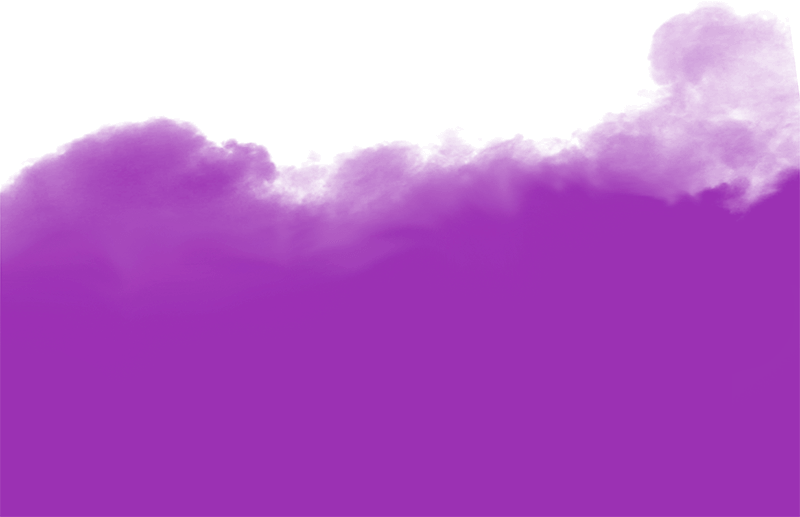

In [120]:
scraper = cloudscraper.create_scraper(delay=15)  
r = scraper.get('https://fbref.com/en/matches/c3b7c811/Egypt-Angola-September-1-2021-WCQ----CAF-M')
soup = BeautifulSoup(r.text, "html.parser")
print(soup.prettify())

In [113]:
scraper = cloudscraper.create_scraper(delay=15)  
r = scraper.get(" https://fbref.com/en/matches/397cba16/Colombia-Brazil-October-10-2021-WCQ----CONMEBOL-M")
soup = BeautifulSoup(r.text, "html.parser")
goalie_div = soup.find('div', id=f'div_keeper_stats_304635c3')
goal_var_table = goalie_div.find('table').find_all('tr')[1]
        
goal_var = []        
        
for var in goal_var_table:
    text = var.text.strip()
    if text:
        goal_var.append(text)

goal_var_id = {name: idx for idx, name in enumerate(goal_var)}
goal_rows = goalie_div.find('table').find('tbody').find_all('tr')


In [114]:
gk_stats = goal_rows[0].find_all('td')
gk_stats[goal_var_id['GA']].text

'4'

In [71]:
goal_var

['Player', 'Age', 'Min', 'SoTA', 'GA', 'Saves', 'Save%']